In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [161]:
df = pd.read_csv('yellow_tripdata_2019-06.csv')
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-06-01 00:55:13,2019-06-01 00:56:17,1.0,0.0,1.0,N,145.0,145.0,2.0,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0
1,1,2019-06-01 00:06:31,2019-06-01 00:06:52,1.0,0.0,1.0,N,262.0,263.0,2.0,2.5,3.0,0.5,0.00,0.0,0.3,6.30,2.5
2,1,2019-06-01 00:17:05,2019-06-01 00:36:38,1.0,4.4,1.0,N,74.0,7.0,2.0,17.5,0.5,0.5,0.00,0.0,0.3,18.80,0.0
3,1,2019-06-01 00:59:02,2019-06-01 00:59:12,0.0,0.8,1.0,N,145.0,145.0,2.0,2.5,1.0,0.5,0.00,0.0,0.3,4.30,0.0
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1.0,1.7,1.0,N,113.0,148.0,1.0,9.5,3.0,0.5,2.65,0.0,0.3,15.95,2.5


In [162]:
print('Number of observations: ', len(df))
print('Number of variables:', len(df.columns))

Number of observations:  3936004
Number of variables: 18


In [163]:
df.isna().sum()

VendorID                 0
tpep_pickup_datetime     1
tpep_dropoff_datetime    1
passenger_count          1
trip_distance            1
RatecodeID               1
store_and_fwd_flag       1
PULocationID             1
DOLocationID             1
payment_type             1
fare_amount              1
extra                    1
mta_tax                  1
tip_amount               1
tolls_amount             1
improvement_surcharge    1
total_amount             1
congestion_surcharge     1
dtype: int64

In [164]:
# some trips report 0 tip. it is assumed that these tips were paid in cash.
df = df[df['tip_amount'] > 0]

# we also remove some outliers, namely those where the tip was 2 times larger than the fare cost
df = df[df['tip_amount'] >= (df['fare_amount'])/2]

# we remove trips with very large fare cost and very low fare
df = df[(df['fare_amount'] >= 2) & (df['fare_amount'] < 400)]

# we drop variables that include the target variable in it, namely the total_amount
clean_data = df.drop(columns='total_amount')

# python already has automatic garbage collection but we want to make sure without having to wait and reply on the gc
# release memory occupied by raw_data as we do not need it anymore
# we are dealing with a large dataset, thus we need to make sure we do not run out of memory
import gc
del df
gc.collect()

0

The number of observations are:  33489
The number of variables are:  17


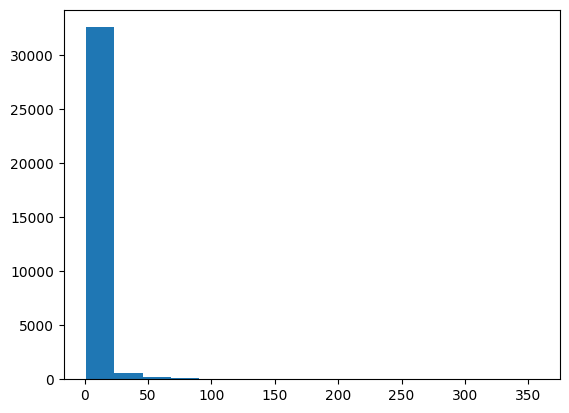

Maximum tip amount is:  356.9
Minimum tip amount is:  1.25
90% of the trip have tip amount less than or equal to:  10.0


In [165]:
print('The number of observations are: ', len(clean_data))
print('The number of variables are: ', len(clean_data.columns))

plt.hist(clean_data['tip_amount'].values, bins=16, histtype='bar')
plt.show()

print('Maximum tip amount is: ', np.max(clean_data['tip_amount']))
print('Minimum tip amount is: ', np.min(clean_data['tip_amount']))
print('90% of the trip have tip amount less than or equal to: ', np.percentile(clean_data['tip_amount'], 90))

In [166]:
clean_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge
83,2,2019-06-01 00:40:25,2019-06-01 00:43:32,1.0,0.72,1.0,N,166.0,238.0,1.0,4.5,0.5,0.5,5.00,0.0,0.3,0.0
145,2,2019-06-01 00:31:51,2019-06-01 00:36:36,1.0,0.57,1.0,N,48.0,170.0,1.0,5.0,0.5,0.5,2.64,0.0,0.3,2.5
164,1,2019-06-01 00:56:08,2019-06-01 01:01:30,1.0,1.00,1.0,N,79.0,4.0,1.0,5.5,3.0,0.5,2.75,0.0,0.3,2.5
290,1,2019-06-01 00:44:37,2019-06-01 00:47:22,2.0,0.50,1.0,N,48.0,230.0,1.0,4.0,3.0,0.5,2.00,0.0,0.3,2.5
361,2,2019-06-01 00:33:18,2019-06-01 00:33:36,1.0,0.00,1.0,N,170.0,170.0,1.0,2.5,0.5,0.5,15.00,0.0,0.3,2.5


In [167]:
# extract datetime using the pandas to_datetime, 
# it doesn't visibly change anything but gives us tool to extract hour, weekday, etc. using dt.
clean_data['tpep_pickup_datetime'] = pd.to_datetime(clean_data['tpep_pickup_datetime'])
clean_data['tpep_dropoff_datetime'] = pd.to_datetime(clean_data['tpep_dropoff_datetime'])
clean_data.head()

clean_data['pickup_hour'] = clean_data['tpep_pickup_datetime'].dt.hour
clean_data['dropoff_hour'] = clean_data['tpep_dropoff_datetime'].dt.weekday

clean_data['pickup_day'] = clean_data['tpep_pickup_datetime'].dt.weekday
clean_data['dropoff_day'] = clean_data['tpep_dropoff_datetime'].dt.weekday

clean_data['trip_time'] = (clean_data['tpep_dropoff_datetime'] - clean_data['tpep_pickup_datetime']).dt.total_seconds()

clean_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,pickup_hour,dropoff_hour,pickup_day,dropoff_day,trip_time
83,2,2019-06-01 00:40:25,2019-06-01 00:43:32,1.0,0.72,1.0,N,166.0,238.0,1.0,...,0.5,5.00,0.0,0.3,0.0,0,5,5,5,187.0
145,2,2019-06-01 00:31:51,2019-06-01 00:36:36,1.0,0.57,1.0,N,48.0,170.0,1.0,...,0.5,2.64,0.0,0.3,2.5,0,5,5,5,285.0
164,1,2019-06-01 00:56:08,2019-06-01 01:01:30,1.0,1.00,1.0,N,79.0,4.0,1.0,...,0.5,2.75,0.0,0.3,2.5,0,5,5,5,322.0
290,1,2019-06-01 00:44:37,2019-06-01 00:47:22,2.0,0.50,1.0,N,48.0,230.0,1.0,...,0.5,2.00,0.0,0.3,2.5,0,5,5,5,165.0
361,2,2019-06-01 00:33:18,2019-06-01 00:33:36,1.0,0.00,1.0,N,170.0,170.0,1.0,...,0.5,15.00,0.0,0.3,2.5,0,5,5,5,18.0


In [168]:
# since we have all the time features that are necessary we can drop the initial datetime variable
clean_data = clean_data.drop(columns=['tpep_pickup_datetime','tpep_dropoff_datetime'])

# some features are categorial so we use one hot encoding using pd.get_dummies()
get_dummy_col = ["VendorID","RatecodeID","store_and_fwd_flag","PULocationID", "DOLocationID","payment_type", "pickup_hour", "dropoff_hour", "pickup_day", "dropoff_day"]
proc_data = pd.get_dummies(clean_data, columns=get_dummy_col)

# for memory managemen we can remove clean_data from memory since we will be using the proc_data
del clean_data
gc.collect()

3989

In [169]:
# now we split the data into dependent and independent(target) matrix
from sklearn.preprocessing import normalize

y = proc_data['tip_amount'].values

# removing the target variable
proc_data = proc_data.drop(columns='tip_amount')
X = proc_data.values

# normalize feature matrix
X = normalize(X, axis=1, norm='l1', copy=False)

print(f'The shape of X is {X.shape}. The shape of y is {y.shape}') 

The shape of X is (33489, 438). The shape of y is (33489,)


In [170]:
# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)
print(f'Shape of X_train is {X_train.shape} and X_test is {X_test.shape}')
print(f'Shape of y_train is {y_train.shape} and y_test is {y_test.shape}')

Shape of X_train is (23442, 438) and X_test is (10047, 438)
Shape of y_train is (23442,) and y_test is (10047,)


In [171]:
# training the model
import time

dt_regression = DecisionTreeRegressor(max_depth=8, random_state=14)
t0 = time.time()
dt_regression.fit(X_train, y_train)
dt_reg_time = time.time() - t0
print('Total time to train(s): ', dt_reg_time)

Total time to train(s):  0.4783501625061035


In [172]:
# prediction

from sklearn.metrics import mean_squared_error 
pred = dt_regression.predict(X_test)
print('The MSE of our model is: ', mean_squared_error(y_test, pred))

The MSE of our model is:  116.74992077777101


In [173]:
# training our model with max_depth = 12
dt_regression2 = DecisionTreeRegressor(max_depth=12, random_state=14)
t0 = time.time()
dt_regression2.fit(X_train,y_train)
dt_reg_time = time.time() - t0
print('Time taken to train(s): ', dt_reg_time)

Time taken to train(s):  0.616591215133667


In [174]:
# comparing the error
pred = dt_regression2.predict(X_test)
print('The MSE of our model is: ', mean_squared_error(y_test, pred))

#result is worse probably because of overfitting

The MSE of our model is:  123.36791755680693
